# TP Final: Análisis del grafo de restaurants de Guía Óleo

## Alumnos: Alan Matys, Barbara Loccoco, Matias Peirano

In [1]:
import pickle
import os
import networkx as nx
from networkx.algorithms import bipartite
from node2vec import Node2Vec
import gensim
import matplotlib.pyplot as plt
import community

c:\Users\Alan\.conda\envs\network\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Consigna

- En este taller se estudiará el grafo proyectado de restaurants que surge a partir de las reseñas que los usuarios de Guía Óleo hacen en el sistema. 

- A continuación se entrega un código que carga y crea el grafo

## Código para cargar el grafo

In [2]:
with open(os.path.join('data','comments_list.p'), "rb") as f:
    comments_list = pickle.load(f)

print(comments_list[0])
print(comments_list[1])

# Creo el grafo que eventualmente será bipartito
G = nx.Graph()

users_nodes = set([])
restaurants_nodes = set([])
user_rest_edges = set([])

for c in comments_list:
    if c["user_num"] not in users_nodes:
        users_nodes.add(c["user_num"])
    if c["rest_url"] not in restaurants_nodes:
        restaurants_nodes.add((c["rest_url"], c["rest_name"]))
    user_rest_edges.add((c["user_num"], c["rest_url"]))

# Agrego la lista de nodos y enlaces al grafo
G.add_nodes_from(users_nodes, bipartite=0)
G.add_nodes_from([(e[0], {"res_name": e[1]}) for e in restaurants_nodes], bipartite=1)
G.add_edges_from(set(user_rest_edges))

# Creo el grafo proyectado
restaurants = [e for e in G.nodes if G.nodes[e]["bipartite"] == 1]
projectionG = bipartite.weighted_projected_graph(G, restaurants)

print('La cantidad de nodos',len(projectionG.nodes))

{'user_num': "b'[\\xe8\\x99,\\x86<J\\xfd\\x88\\xf5\\x8dS[\\xdeE\\xca'", 'rest_name': 'Pertutti', 'rest_url': '/restaurantes/Pertutti-11248', 'comments': 'La verdad, coincido con la mayoría de los comentarios. Fui hoy al mediodía para comer algo rápido, esquivando la cantidad de gente que había en el shopping de enfrente. Pedí un filet a la romana con puré de papas, mi mujer unos spaghetti del menú light y el nene ñoquis del menú infantil. Mi puré y lo de mi esposa no tenía gusto NADA. La atención, mala. El mozo nos volcó un vaso y nos tiró un trapo sucio que pasó así no más y se fue. Lo único respetable fue la panera y el helado del postre infantil. Y caro. No volveré.'}
{'user_num': "b'[\\xe8\\x99,\\x86<J\\xfd\\x88\\xf5\\x8dS[\\xdeE\\xca'", 'rest_name': 'Justo! Brandzen', 'rest_url': '/restaurantes/Justo-Brandzen-9216', 'comments': 'Lindo lugar, atención correcta y buena comida. Me parece un buen lugar para comer en Quilmes con muy buena relación calidad/precio. Lo único que podría cr

## Limpieza

Una vez creado el grafo proyectado, se aplican ciertos criterios de limpieza de datos para obtener un grafo mas rico y con menos Nodos y Ejes poco relevantes.

Limpiezas:
1. Eliminar todos los ejes que tienen un peso igual a 1
2. Eliminar todos los Nodos cuyo degree = 0

In [3]:
def feature_eng(G):
    """
    Limpieza de ciertos nodos y ejes poco relevantes par el analysis
    """

    # Creo una lista por comprension para obtener todos los ejes en donde su peso es igual a 1
    edges_with_1 = [(u,v) for u,v,d in G.edges(data = True) if d['weight'] == 1]

    # Remuevo los ejes de mi Red
    G.remove_edges_from(edges_with_1)

    # Creo una lista por comprension apra obtener todos los nodos cuyo degree es igual a 0
    nodes = [n for n in projectionG.nodes() if len(list(G.neighbors(n))) == 0]

    # Remuevo esos nodos de mi Red
    G.remove_nodes_from(nodes)

    # Se exporta al formato gexf para poder ser visualizado en Gephi
    if os.path.exists(os.path.join('data',"commentnet.gexf")) == False:
        nx.write_gexf(G,"commentnet.gexf")

    return projectionG

3. Exporten la red en formato gexf

In [4]:
clean_G = feature_eng(projectionG)

## Visualizacion en Gephi (Software especifico para visualizacion de Grafos de mayor dimension)
- Al grafo calculado se le aplican el valor de la modularidad, segun su valor de modularidad, tamaño de nodos usando PageRank y 


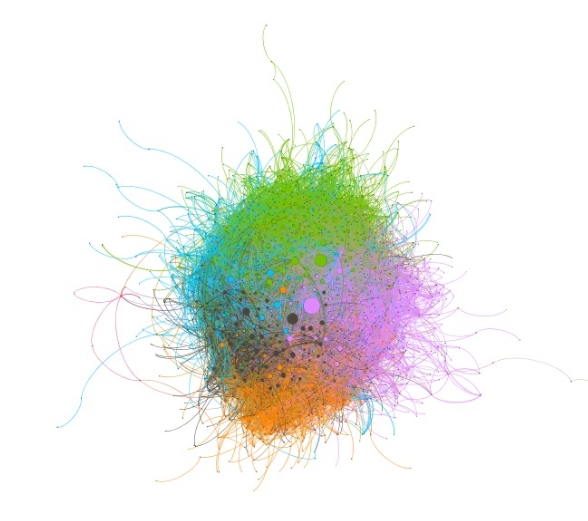

In [5]:
from IPython.display import Image
Image(filename=os.path.join('plots','viz.png'), width=1000, height=1000)

## Triangulos Restaurantes Preferidos

Probamos cuantos Restaurantes estan en un Triangulo con nuestros preferidos:
- Sarkis
- Kansas
- Don Julio

In [7]:
# Escribo una funcion para revisar que restaurants estan en un triangulo con mi Restaurant preferido Sarkis.
from itertools import combinations
def nodes_in_triangle(G, n):

    triangle_nodes = set([n])

    # Itero pro sobre todas las posibles combinaciones de realciones triangulares
    for n1, n2 in combinations(G.neighbors(n),2):

        # Reviso si hay un nodo entre n1 y n2
        if G.has_edge(n1,n2):

            # Agrego n1 al set de nodos
            triangle_nodes.add(n1)

            # Agrego n2 al set de nodos
            triangle_nodes.add(n2)

    return triangle_nodes

# Busco el nodo con mi restaurante preferido
sarkis = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Sarkis']

kansas = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Kansas Grill & Bar']

donjulio = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Don Julio']

# Le pido a la funcion que me devuelva aquelos nodos
print('Cantidad de Restaurants en Triangulo con Sarkis',len(nodes_in_triangle(clean_G,sarkis[0])))

print('Cantidad de Restaurants en Triangulo con Kansas',len(nodes_in_triangle(clean_G,kansas[0])))

print('Cantidad de Restaurants en Triangulo con Don Julio',len(nodes_in_triangle(clean_G,donjulio[0])))

Cantidad de Restaurants en Triangulo con Sarkis 585
Cantidad de Restaurants en Triangulo con Kansas 413
Cantidad de Restaurants en Triangulo con Don Julio 187


In [8]:
import community
#import pacmap
res_pr = nx.pagerank(clean_G)
res_pr = sorted([e for e in res_pr.items()], key=lambda x: x[1], reverse=True)

RETRAIN_RES = False

if RETRAIN_RES:

    res_vectors = Node2Vec(clean_G, dimensions=32, walk_length=40, num_walks=64, workers=4)

    res_model = res_vectors.fit(window=2, min_count=1, negative=10)

    vocabulary = list(res_model.wv.index_to_key)
    X = res_model.wv.get_normed_vectors()

    res_model.save("restaurants_n2v.model")

    embedding = pacmap.PaCMAP(
        n_dims=2,
        n_neighbors=None,
        MN_ratio=0.5,
        FP_ratio=2.0
    ).fit_transform(X)

    with open("res_embedding.p", "wb") as f:
        pickle.dump((X, vocabulary, embedding ), f)

else:

    res_model = gensim.models.Word2Vec.load(os.path.join("models","restaurants_n2v.model"))

    with open(os.path.join("models","res_embedding.p"), "rb") as f:
        X, vocabulary, embedding = pickle.load(f)

print('Similares a Guerrin: ',res_model.wv.most_similar('/restaurantes/Guerrin-499', topn=5),'\n')
print('Similares a Kansas: ',res_model.wv.most_similar('/restaurantes/Kansas-American-Cuisine-1182', topn=5),'\n')
print('Similares a Sarkis: ',res_model.wv.most_similar('/restaurantes/Sarkis-48', topn=5),'\n')
print('Similares a Don Julio: ',res_model.wv.most_similar('/restaurantes/Don-Julio-802', topn=5),'\n')

Similares a Guerrin:  [('/restaurantes/Cafe-Tortoni-1377', 0.8951521515846252), ('/restaurantes/La-Continental-1957', 0.8806291222572327), ('/restaurantes/Campo-dei-Fiori-2239', 0.8800485134124756), ('/restaurantes/La-Nueva-Calesita-2648', 0.8795108795166016), ('/restaurantes/El-Molino-Dorado-8562', 0.8744094967842102)] 

Similares a Kansas:  [('/restaurantes/Melo-2135', 0.9037309288978577), ('/restaurantes/Azul-Profundo-557', 0.9024205207824707), ('/restaurantes/Como-en-Casa-2230', 0.9000488519668579), ('/restaurantes/Kentucky-1858', 0.8959578275680542), ('/restaurantes/Cangas-del-Narcea-363', 0.8886750340461731)] 

Similares a Sarkis:  [('/restaurantes/Bangalore-2740', 0.9368208050727844), ('/restaurantes/La-Dorita-Botanico-6322', 0.9297439455986023), ('/restaurantes/Sullivans-Irish-Pub-Restaurant-1123', 0.9285507798194885), ('/restaurantes/Romario-3361', 0.9266986846923828), ('/restaurantes/Isabel-7784', 0.9226678609848022)] 

Similares a Don Julio:  [('/restaurantes/Elebar-3564', 0

C:\Users\Alan\AppData\Local\Temp\ipykernel_13056\4231100821.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis', max(partition.values()) + 1)


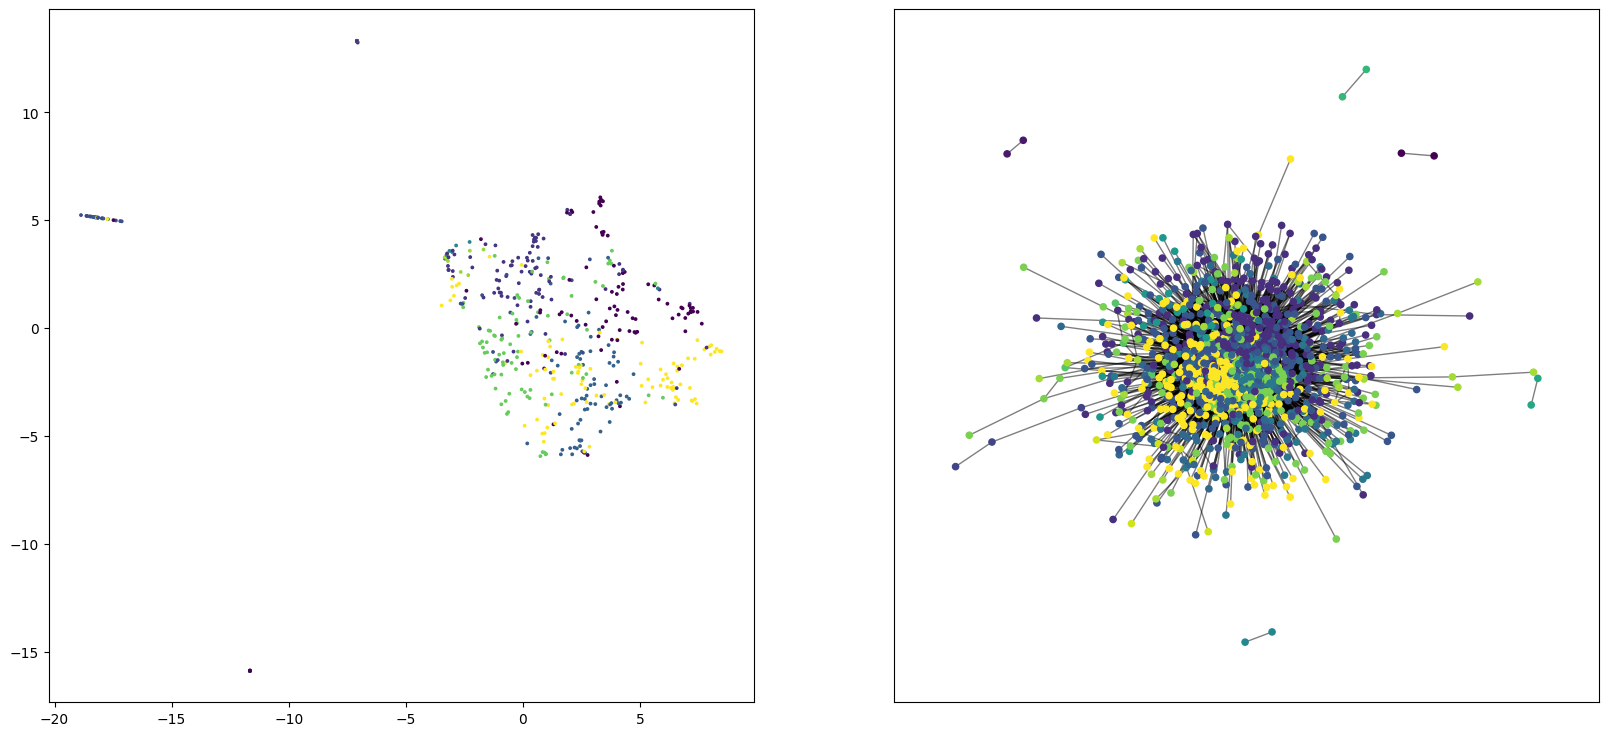

In [10]:
import matplotlib as mpl

partition = community.best_partition(clean_G, weight='weight')

fig, ax = plt.subplots(ncols = 2, figsize=(20,9))

ax[0].scatter(embedding[:, 0],
            embedding[:, 1],
            s=3,
            c = [partition[n] for n in vocabulary])

pos = nx.spring_layout(clean_G,k=0.12,seed=42)
cmap = mpl.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(clean_G, pos, partition.keys(), node_size=20,cmap=cmap, node_color=list(partition.values()),ax=ax[1])
nx.draw_networkx_edges(clean_G, pos, alpha=0.5,ax=ax[1])

plt.show()